<a href="https://colab.research.google.com/github/pragatipatel26/Image-Processing/blob/main/Segmentation_based_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
def load_images(data_dir):
    images, labels = [], []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(root, file)
                label = os.path.basename(root)  # Class name as label
                image = cv2.imread(image_path)
                image = cv2.resize(image, (256, 256))  # Resize for uniformity
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/My Drive/Dataset.zip"
extract_path = "/content/dataset"  # Local extraction folder in Colab

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)

Extracted to: /content/dataset


In [ ]:
import os
for root, dirs, files in os.walk(extract_path):
    print( root)
    for f in files[:5]:  # show only a few files per folder
        print("   └──", f)

/content/dataset
   └── README.roboflow.txt
   └── README.dataset.txt
/content/dataset/train
   └── f7f2d555c_jpg.rf.357450df0168552824095eb6cd5265a3.jpg
   └── 0f8305adb_jpg.rf.64c0df7992f3a51d6f1d6aece8cf6779.jpg
   └── 62a62b552_jpg.rf.88cb188382ee29074c4863140040c59c.jpg
   └── aff405a28_jpg.rf.789afdc44feb3ec0f3a14a154a4a32d0.jpg
   └── ed22af554_jpg.rf.f00cb8300365b8d345304f27c07d19ce.jpg
/content/dataset/test
   └── 8ceba5ea5_jpg.rf.1cf328ea02e3f5751be6e87d6b49f0a3.jpg
   └── a493cde22_jpg.rf.b8c594cc17afcac631010d9dd63ad76c.jpg
   └── 370b998e7_jpg.rf.035145e210cbc858e9d905fd93e9c9af.jpg
   └── 60d7248a8_jpg.rf.bea39406c581822e28edcbc3b4fb629c.jpg
   └── 0a9a7a6c7_jpg.rf.17ae32f944e04779f6748c38dd85c707.jpg
/content/dataset/valid
   └── 9bf863558_jpg.rf.df31a02f325c8a411d8dabc06355fedc.jpg
   └── d81eb8a93_jpg.rf.3bc6d0b4680d39c0d6d1cc6cee01f982.jpg
   └── cf5e8eb2c_jpg.rf.3cb5c1ccf1698f003d62ac135caf9254.jpg
   └── 25b57b528_jpg.rf.6b849ec680289079ad8a9536ed60e01d.jpg
   └── 0

In [ ]:
import glob

# Look for all CSV and Excel files in the dataset directory
csv_files = glob.glob("/content/dataset/**/*.csv", recursive=True)
excel_files = glob.glob("/content/dataset/**/*.xlsx", recursive=True)

print("CSV files found:", csv_files)
print("Excel files found:", excel_files)

CSV files found: ['/content/dataset/train/_annotations.csv', '/content/dataset/test/_annotations.csv', '/content/dataset/valid/_annotations.csv']
Excel files found: []


In [ ]:
import pandas as pd

train_csv = "/content/dataset/train/_annotations.csv"
df_train = pd.read_csv(train_csv)
print("Train CSV columns:\n", df_train.columns)
print("\nSample rows:")
print(df_train.head())

Train CSV columns:
 Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

Sample rows:
                                            filename  width  height  \
0  6212e44a0_jpg.rf.eca9d0d2821273911813398f6cf9b...    512     256   
1  6212e44a0_jpg.rf.eca9d0d2821273911813398f6cf9b...    512     256   
2  43b6618bf_jpg.rf.ec7a7bcb21bcc7881051906d564ba...    512     256   
3  43b6618bf_jpg.rf.ec7a7bcb21bcc7881051906d564ba...    512     256   
4  43b6618bf_jpg.rf.ec7a7bcb21bcc7881051906d564ba...    512     256   

            class  xmin  ymin  xmax  ymax  
0  scratch defect   488   104   493   172  
1  scratch defect   164     1   169    84  
2  scratch defect   212   130   221   184  
3  scratch defect    93   113   107   162  
4  scratch defect   230     0   247    20  


In [ ]:
# Group by filename and take the first class label (assumes all boxes in one image belong to same class)
df_class = df_train.groupby('filename')['class'].first().reset_index()


#df_class['class'] = df_class['class'].str.replace(" defect", "", regex=False)
print(df_class['class'].value_counts())  # See class distribution

# Save for later use
df_class.to_csv("/content/train_labels.csv", index=False)

class
scratch defect           8070
pitted surface defect    1404
patch defect              826
crazing defect            330
Name: count, dtype: int64


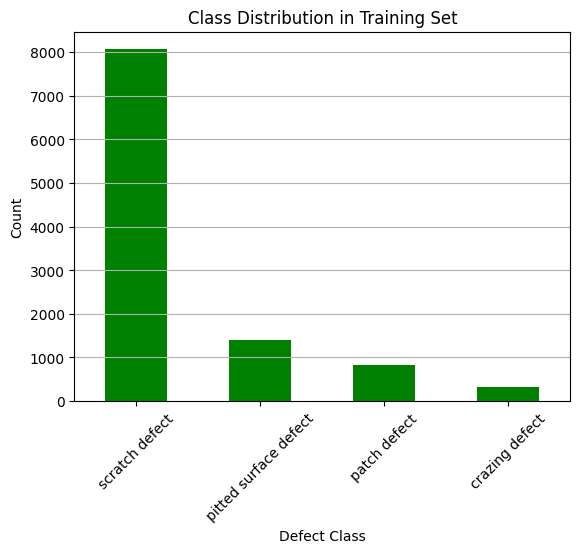

In [ ]:
#visualization of class distribution
import matplotlib.pyplot as plt

df_class['class'].value_counts().plot(kind='bar', color='green')
plt.title("Class Distribution in Training Set")
plt.xlabel("Defect Class")
import matplotlib.pyplot as plt

df_class['class'].value_counts().plot(kind='bar', color='green')
plt.title("Class Distribution in Training Set")
plt.xlabel("Defect Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
#plt.grid(axis='x')
plt.show()

In [ ]:
#image preprocessing using imagedatagenerator class in keras
IMG_SIZE = (128,128)
BATCH_SIZE = 64

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

#test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#creation of train,valid and test dataframe
import pandas as pd
import os

# Define base directories
base_dir = "/content/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# Load CSV files
train_csv = pd.read_csv(os.path.join(train_dir, "_annotations.csv"))
val_csv = pd.read_csv(os.path.join(val_dir, "_annotations.csv"))
test_csv = pd.read_csv(os.path.join(test_dir, "_annotations.csv"))


In [ ]:
# Drop duplicate labels per image
train_df = train_csv[['filename', 'class']].drop_duplicates()
val_df = val_csv[['filename', 'class']].drop_duplicates()
test_df = test_csv[['filename', 'class']].drop_duplicates()


In [ ]:
# Add image paths
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x))
val_df['filepath'] = val_df['filename'].apply(lambda x: os.path.join(val_dir, x))
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_dir, x))


In [ ]:
# Encode class labels into integers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
all_classes = train_df['class'].tolist() + val_df['class'].tolist() + test_df['class'].tolist()
le.fit(all_classes)

train_df['label'] = le.transform(train_df['class'])
val_df['label'] = le.transform(val_df['class'])
test_df['label'] = le.transform(test_df['class'])

# Optional: Keep class index mapping for later use
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {np.str_('crazing defect'): np.int64(0), np.str_('patch defect'): np.int64(1), np.str_('pitted surface defect'): np.int64(2), np.str_('scratch defect'): np.int64(3)}


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 11304 validated image filenames belonging to 4 classes.
Found 710 validated image filenames belonging to 4 classes.
Found 707 validated image filenames belonging to 4 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import cv2

class SegmentationDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, img_size, method='canny', shuffle=True, num_classes=4):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size  # (width, height)
        self.shuffle = shuffle
        self.method = method
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        images, labels = [], []

        for _, row in batch_df.iterrows():
            img = cv2.imread(row['filepath'])
            if img is None:
                raise ValueError(f"Could not read image: {row['filepath']}")
            processed_img = self.apply_masking(img)
            processed_img = cv2.resize(processed_img, self.img_size)
            processed_img = processed_img.astype(np.float32) / 255.0
            images.append(processed_img)
            labels.append(row['label'])

        X = np.array(images)
        y = tf.keras.utils.to_categorical(labels, num_classes=self.num_classes)
        return X, y

    def apply_masking(self, img):
        if self.method == 'canny':
            return self.mask_canny(img)
        elif self.method == 'otsu':
            return self.mask_otsu(img)
        elif self.method == 'crop':
            return self.crop_by_contours(img)
        else:
            raise ValueError(f"Unknown method: {self.method}")

    def mask_canny(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.dilate(edges, kernel, iterations=1)
        return cv2.bitwise_and(img, img, mask=mask)

    def mask_otsu(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return cv2.bitwise_and(img, img, mask=mask)

    def crop_by_contours(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            crop = img[y:y+h, x:x+w]
            return cv2.resize(crop, self.img_size)
        else:
            return cv2.resize(img, self.img_size)


In [ ]:
IMG_SIZE = (128,128)
BATCH_SIZE = 64

# Try different methods like 'canny', 'otsu', 'crop'
train_gen_canny = SegmentationDataGenerator(train_df, BATCH_SIZE, IMG_SIZE, method='canny', shuffle=True)
val_gen_canny   = SegmentationDataGenerator(val_df,   BATCH_SIZE, IMG_SIZE, method='canny', shuffle=False)

train_gen_otsu = SegmentationDataGenerator(train_df, BATCH_SIZE, IMG_SIZE, method='otsu', shuffle=True)
val_gen_otsu   = SegmentationDataGenerator(val_df,   BATCH_SIZE, IMG_SIZE, method='otsu', shuffle=False)

train_gen_crop = SegmentationDataGenerator(train_df, BATCH_SIZE, IMG_SIZE, method='crop', shuffle=True)
val_gen_crop   = SegmentationDataGenerator(val_df,   BATCH_SIZE, IMG_SIZE, method='crop', shuffle=False)


In [ ]:
from tensorflow.keras import layers, models

# Define CNN model
def create_cnn_model(input_shape=(128,128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Set the batch size
BATCH_SIZE = 64

# Instantiate the model
cnn_model = create_cnn_model()






/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)

# Map to index format required by model.fit()
class_indices = train_gen.class_indices
weights_dict = {class_indices[cls]: w for cls, w in zip(np.unique(train_df['class']), class_weights)}

#print("Class weights for training:", weights_dict)
print("Class Indices and Weights:")
for cls, index in class_indices.items():
    weight = weights_dict[index]
    print(f"Class: {cls}, Index: {index}, Weight: {weight}")


Class Indices and Weights:
Class: crazing defect, Index: 0, Weight: 7.209183673469388
Class: patch defect, Index: 1, Weight: 2.204368174726989
Class: pitted surface defect, Index: 2, Weight: 2.0128205128205128
Class: scratch defect, Index: 3, Weight: 0.3435448577680525


In [ ]:
cnn_model.fit(
    train_gen_canny,
    steps_per_epoch=len(train_gen_canny),  # fixed
    epochs=5,
    validation_data=val_gen_canny,
    validation_steps=len(val_gen_canny),  # fixed
    class_weight={i: class_weights[i] for i in range(len(class_weights))}
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.4887 - loss: 1.3105 - val_accuracy: 0.4479 - val_loss: 1.0345
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.4115 - loss: 0.9935 - val_accuracy: 0.5141 - val_loss: 1.0011
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.4791 - loss: 0.8459 - val_accuracy: 0.5930 - val_loss: 0.8711
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.5302 - loss: 0.7448 - val_accuracy: 0.6676 - val_loss: 0.7786
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.6048 - loss: 0.6303 - val_accuracy: 0.6775 - val_loss: 0.7703


In [ ]:
# Assuming you've already encoded test_df['label'] with LabelEncoder as 'label'
test_gen_canny = SegmentationDataGenerator(test_df, BATCH_SIZE, IMG_SIZE, method='canny', shuffle=False)

# Predict probabilities
y_probs = cnn_model.predict(test_gen_canny)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_probs, axis=1)

# True labels
y_true = test_df['label'].values

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 669ms/step


In [ ]:
loss, acc = cnn_model.evaluate(test_gen_canny)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 774ms/step - accuracy: 0.6563 - loss: 0.8574
Test Loss: 0.7845
Test Accuracy: 0.6690


In [ ]:
from sklearn.metrics import classification_report

# If you used LabelEncoder before, you can inverse transform to get class names
class_names = le.classes_

print(classification_report(y_true, y_pred, target_names=class_names))


                       precision    recall  f1-score   support

       crazing defect       0.46      0.75      0.57        24
         patch defect       0.33      0.64      0.43        84
pitted surface defect       0.49      0.61      0.54        89
       scratch defect       0.88      0.68      0.77       510

             accuracy                           0.67       707
            macro avg       0.54      0.67      0.58       707
         weighted avg       0.75      0.67      0.69       707



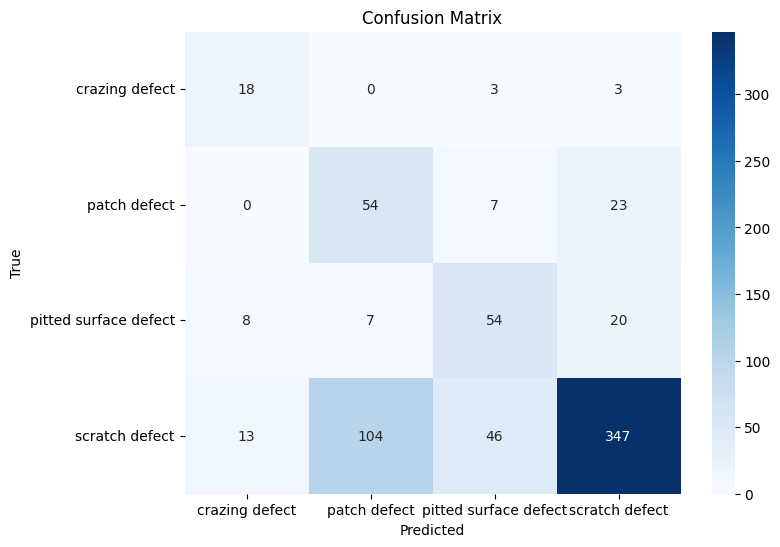

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
cnn_model.fit(
    train_gen_otsu,
    steps_per_epoch=len(train_gen_otsu),  # fixed
    epochs=5,
    validation_data=val_gen_otsu,
    validation_steps=len(val_gen_otsu),  # fixed
    class_weight={i: class_weights[i] for i in range(len(class_weights))}
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.4599 - loss: 0.9327 - val_accuracy: 0.5465 - val_loss: 0.9221
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.5715 - loss: 0.7175 - val_accuracy: 0.5549 - val_loss: 0.9137
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.6528 - loss: 0.5578 - val_accuracy: 0.6380 - val_loss: 0.8579
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.7297 - loss: 0.4567 - val_accuracy: 0.6803 - val_loss: 0.7948
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.7816 - loss: 0.3861 - val_accuracy: 0.7408 - val_loss: 0.6613


In [ ]:
# Assuming you've already encoded test_df['label'] with LabelEncoder as 'label'
test_gen_otsu = SegmentationDataGenerator(test_df, BATCH_SIZE, IMG_SIZE, method='otsu', shuffle=False)

# Predict probabilities
y_probs = cnn_model.predict(test_gen_otsu)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_probs, axis=1)

# True labels
y_true = test_df['label'].values

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step


In [ ]:
loss, acc = cnn_model.evaluate(test_gen_canny)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 697ms/step - accuracy: 0.6596 - loss: 4.7205
Test Loss: 5.0121
Test Accuracy: 0.6605


In [ ]:
from sklearn.metrics import classification_report

class_names = le.classes_

print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

       crazing defect       0.25      0.08      0.12        24
         patch defect       0.23      0.67      0.34        84
pitted surface defect       0.57      0.27      0.37        89
       scratch defect       0.80      0.64      0.71       510

             accuracy                           0.58       707
            macro avg       0.46      0.42      0.39       707
         weighted avg       0.68      0.58      0.60       707



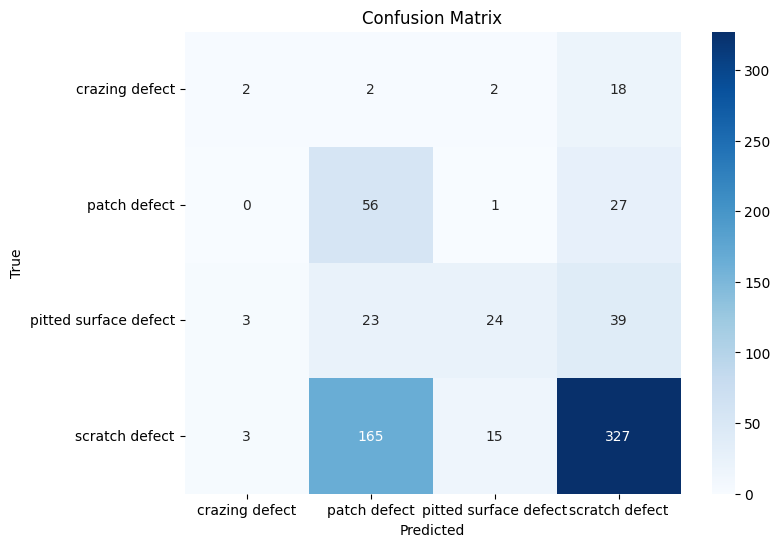

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cnn_model.fit(
    train_gen_crop,
    steps_per_epoch=len(train_gen_crop),  # fixed
    epochs=5,
    validation_data=val_gen_crop,
    validation_steps=len(val_gen_crop),  # fixed
    class_weight={i: class_weights[i] for i in range(len(class_weights))}
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.3181 - loss: 1.2583 - val_accuracy: 0.3563 - val_loss: 1.2058
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.4220 - loss: 1.0405 - val_accuracy: 0.5831 - val_loss: 0.9043
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.4637 - loss: 0.9451 - val_accuracy: 0.6014 - val_loss: 0.8536
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.5500 - loss: 0.7653 - val_accuracy: 0.6296 - val_loss: 0.8089
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.6035 - loss: 0.6824 - val_accuracy: 0.6127 - val_loss: 0.8735


In [ ]:

test_gen_crop = SegmentationDataGenerator(test_df, BATCH_SIZE, IMG_SIZE, method='crop', shuffle=False)

# Predict probabilities
y_probs = cnn_model.predict(test_gen_crop)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_probs, axis=1)

# True labels
y_true = test_df['label'].values

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 802ms/step


In [ ]:
loss, acc = cnn_model.evaluate(test_gen_crop)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 961ms/step - accuracy: 0.5116 - loss: 1.1135
Test Loss: 1.0042
Test Accuracy: 0.5460


In [ ]:
from sklearn.metrics import classification_report

class_names = le.classes_

print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

       crazing defect       0.31      0.46      0.37        24
         patch defect       0.29      0.77      0.42        84
pitted surface defect       0.37      0.75      0.49        89
       scratch defect       0.92      0.48      0.63       510

             accuracy                           0.55       707
            macro avg       0.47      0.62      0.48       707
         weighted avg       0.75      0.55      0.58       707



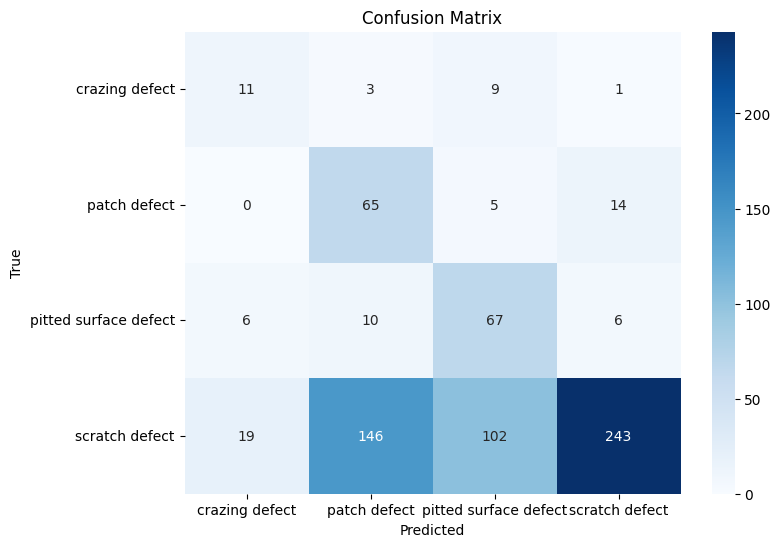

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()